In [1]:
import numpy as np
import pandas as pd

from ensalada.session import Session
from ensalada.model import LabeledLDA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='ticks', context='talk')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [2]:
sess = Session("AJF027", "CDEF", 2, bin_size=0.1)

In [3]:
X, y, lengths = sess.format_online_data(pre=2, post=1)

In [4]:
trial_idx = np.concatenate([[i] * n for i, n in enumerate(lengths)])

In [5]:
model_list = []
for n in range(5):
    print(n)
    mdl = LabeledLDA(n_components=1, n_iter=10000)  # n_components=0 == no background
    mdl.fit(X, y)
    model_list.append(mdl)

0
1
2
3
4


In [6]:
best_model_idx = np.argmin([m.perplexity_[-1] for m in model_list])

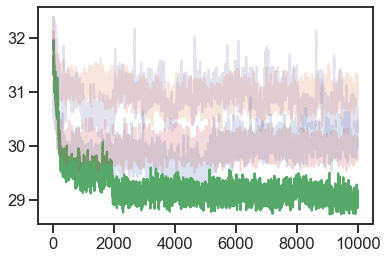

In [7]:
plt.figure()
for i, m in enumerate(model_list):
    plt.plot(m.perplexity_, alpha=1 if i == best_model_idx else 0.2)

In [8]:
mdl = model_list[best_model_idx]

In [9]:
doc_topic_dist = mdl.transform(X)

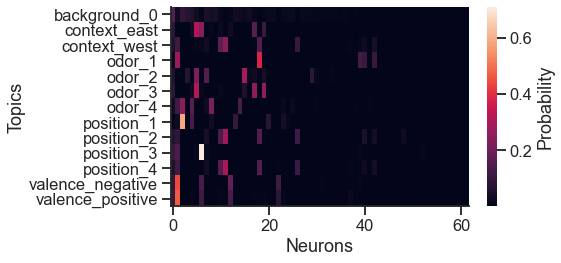

In [10]:
labels = mdl.component_labels_
label_order = np.argsort(labels)

plt.figure(figsize=(8, 4))
sns.heatmap(mdl.components_[label_order], xticklabels=20, cbar_kws={'label': 'Probability'})
plt.yticks(np.arange(13) + 0.5, mdl.component_labels_[label_order], rotation=0)
plt.xlabel('Neurons')
plt.ylabel('Topics')

sns.despine()
plt.tight_layout()

#plt.savefig('topic_word_dist.pdf')

<AxesSubplot:>

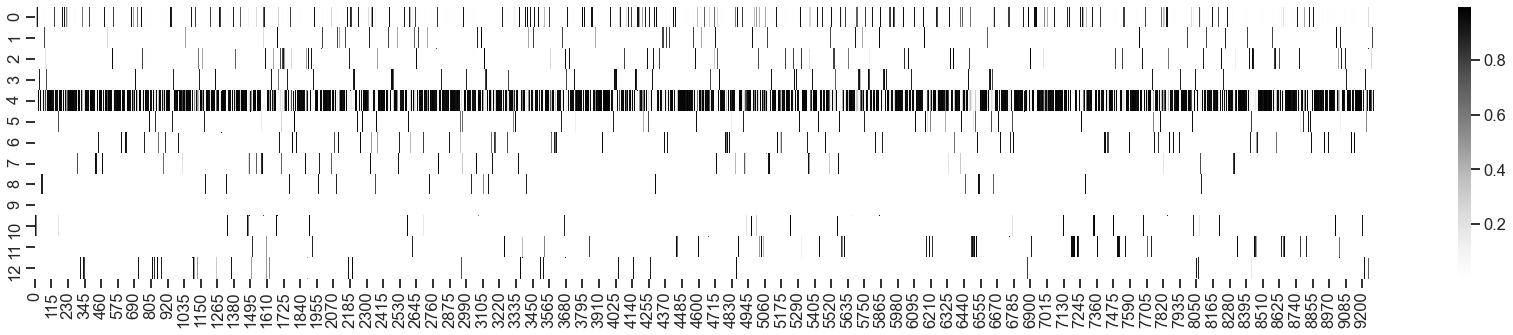

In [11]:
plt.figure(figsize=(30, 5))
sns.heatmap(doc_topic_dist.T, cmap='Greys')
#plt.xlim(0, lengths[0])
#plt.axvline(30, color='g')

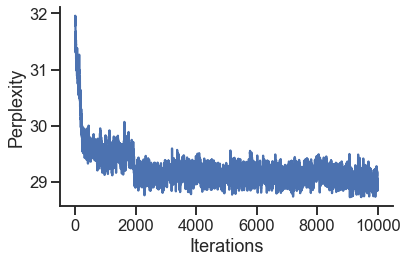

In [12]:
plt.figure()
plt.plot(mdl.perplexity_)
plt.ylabel('Perplexity')
plt.xlabel('Iterations')

sns.despine()
plt.tight_layout()

#plt.savefig("convergence_best.pdf")

In [13]:
trial_topics = np.stack([doc_topic_dist[trial_idx==n][0:34] for n in np.unique(trial_idx)])
avg_trial_topics = np.nanmean(trial_topics, axis=0).T

In [14]:
avg_trial_topics.T

array([[1.96017385e-01, 5.64319901e-02, 2.13935878e-02, 7.95545615e-03,
        4.99516875e-01, 3.93737257e-02, 2.06582644e-03, 8.80988166e-02,
        3.71231250e-02, 1.13165792e-04, 4.24598642e-02, 8.29177443e-03,
        1.15827238e-03],
       [2.53355712e-01, 7.06472248e-02, 7.40316743e-03, 8.18569493e-03,
        4.57355499e-01, 4.23903540e-02, 2.93484442e-02, 5.00844046e-02,
        2.14480907e-02, 1.12078873e-04, 5.60295694e-02, 2.49258010e-03,
        1.14714785e-03],
       [2.23950863e-01, 5.20812683e-02, 1.41127314e-02, 6.93586841e-03,
        4.63684022e-01, 5.19751869e-02, 1.88469663e-02, 5.48685081e-02,
        4.60540168e-02, 5.86091587e-03, 5.72691709e-02, 2.32920796e-03,
        2.03132466e-03],
       [2.14801490e-01, 2.57186834e-02, 1.16853695e-02, 1.39466417e-03,
        4.82118428e-01, 8.38658512e-02, 1.92125868e-02, 6.65319636e-02,
        2.48152353e-02, 1.02519523e-04, 6.19405545e-02, 2.27998290e-03,
        5.53263165e-03],
       [1.98708311e-01, 5.90983219e-

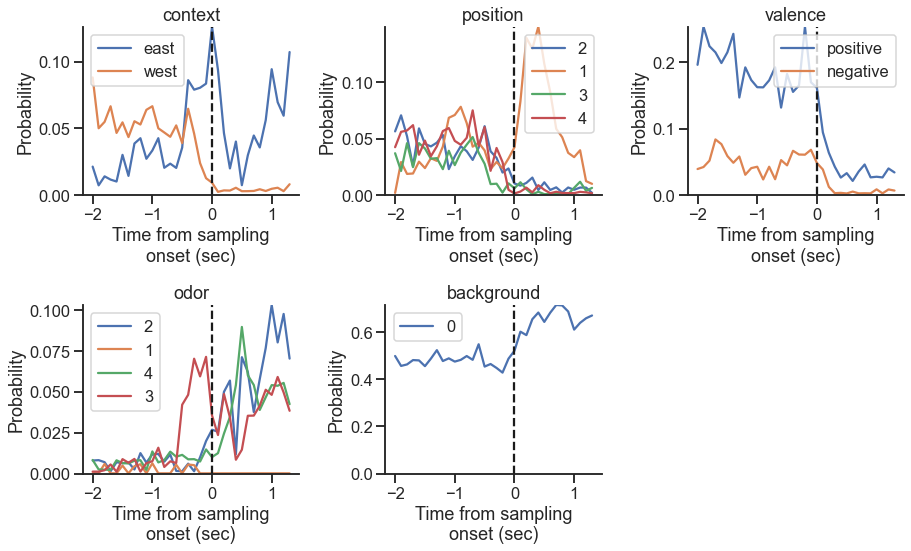

In [15]:
def make_psth(category, topics, labels):
    
    category_filt = np.array([category in l for l in labels])
    for l, c in zip(labels[category_filt], topics[category_filt]):
        plt.plot(np.arange(-2, 1.40, 0.1), c, label=l.replace(f'{category}_', ''))
    plt.axvline(0, color='k', linestyle='--')
    plt.ylim([0, np.max(topics[category_filt])])
    plt.ylabel('Probability')
    plt.xlabel('Time from sampling\nonset (sec)')
    plt.title(category)
    plt.legend()


plt.figure(figsize=(13, 8))

plt.subplot(2, 3, 1)
make_psth('context', avg_trial_topics, labels)
plt.subplot(2, 3, 2)
make_psth('position', avg_trial_topics, labels)
plt.subplot(2, 3, 3)
make_psth('valence', avg_trial_topics, labels)
plt.subplot(2, 3, 4)
make_psth('odor', avg_trial_topics, labels)
plt.subplot(2, 3, 5)
make_psth('background', avg_trial_topics, labels)

sns.despine()
plt.tight_layout()

#plt.savefig('sampling_topics.pdf')



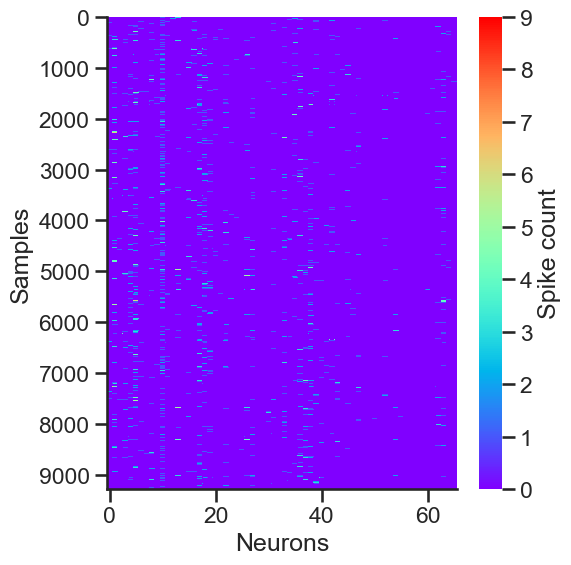

In [16]:
plt.figure(figsize=(6, 6), dpi=100)
sns.heatmap(X, cmap='rainbow', yticklabels=1000, xticklabels=20, cbar_kws={'label': 'Spike count'}, rasterized=True)
plt.ylabel('Samples')
plt.xlabel('Neurons')
plt.yticks(rotation=None)

sns.despine()
plt.tight_layout()

plt.savefig('raw_data_correct.pdf')

In [17]:
X_offline = sess.format_offline_data()

/home/james/code/neural_slda/ensalada/session.py:93: RuntimeWarning: invalid value encountered in greater
  delta_pos[delta_pos > cutoff] = np.nan  # remove outrageous numbers


In [50]:
offline_topics = mdl.transform(X_offline)[:, label_order]

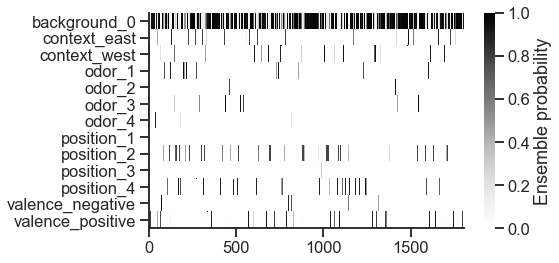

In [51]:
plt.figure(figsize=(8, 4))
sns.heatmap(offline_topics.T, cmap='Greys',
            vmin=0, vmax=1, cbar_kws={'label': 'Ensemble probability'},
            xticklabels=500)
plt.yticks(np.arange(13) + 0.5, mdl.component_labels_[label_order], 
           rotation=0)

sns.despine()
plt.tight_layout()

plt.savefig('offline_topic_probs.pdf')

/home/james/miniconda3/envs/lab/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


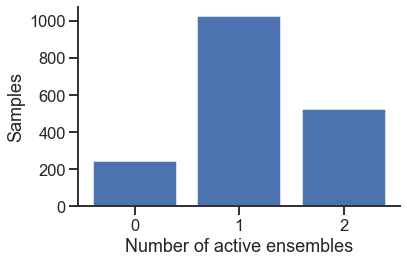

In [115]:
bin_counts = np.histogram((offline_topics > 0.05).sum(axis=1), np.arange(-0.5, 3))[0]

plt.figure()
plt.bar(np.arange(0, 3), bin_counts)
plt.ylabel('Samples')
plt.xlabel('Number of active ensembles')
sns.despine()
plt.tight_layout()
plt.savefig('offline_topic_counts.pdf')

In [82]:
multi_topic_samples = offline_topics[
    (offline_topics > 0.05).sum(axis=1) == 2
]

/home/james/miniconda3/envs/lab/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [129]:
replay_topics = []
for theta in multi_topic_samples:
    
    l = np.sort(labels)[np.where(theta > 0.05)[0]]
    if 'background_0' in l:
        continue
    else:
        replay_topics.append(np.sort(l))

In [130]:
replay_topics = [f"{t[0]} - {t[1]}" for t in replay_topics]

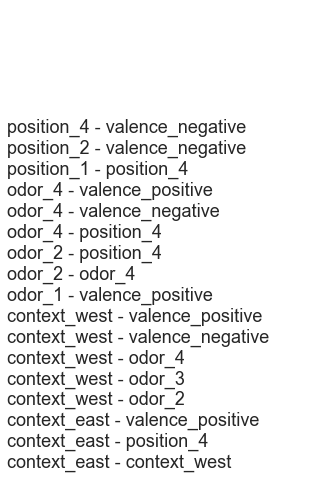

In [131]:
plt.figure(figsize=(5, 7))
ax = plt.subplot(111)
for tidx, t in enumerate(np.unique(replay_topics)):
    ax.text(0, tidx, t)
plt.ylim([0, 22])
plt.axis('off')
plt.tight_layout()
plt.savefig('offline_multi_topic_names.pdf')

In [133]:
np.sum(np.isnan(offline_topics))

3159

array(['context_east - context_west', 'context_east - position_4',
       'context_east - valence_positive', 'context_west - odor_2',
       'context_west - odor_3', 'context_west - odor_4',
       'context_west - valence_negative',
       'context_west - valence_positive', 'odor_1 - valence_positive',
       'odor_2 - odor_4', 'odor_2 - position_4', 'odor_4 - position_4',
       'odor_4 - valence_negative', 'odor_4 - valence_positive',
       'position_1 - position_4', 'position_2 - valence_negative',
       'position_4 - valence_negative'], dtype='<U31')